<a href="https://colab.research.google.com/github/agrr12/TCC/blob/master/TCC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
!pip install pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql.functions import *
from google.colab import drive
from pyspark.sql.types import *
import numpy as np
from scipy import sparse
from datetime import *
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import warnings
import seaborn as sns
from PIL import Image
from collections import Counter
from matplotlib.ticker import MaxNLocator
from pyspark.sql.window import Window

In [38]:
def create_sparse_matrix(start_date_str: str, end_date_str: str, unit: str = 'seconds') -> sparse.dok_matrix:
    """
    Create a sparse matrix based on the difference between two date strings.

    Parameters:
    - start_date_str (str): Start date in the format '%Y-%m-%d %H:%M:%S'.
    - end_date_str (str): End date in the format '%Y-%m-%d %H:%M:%S'.
    - unit (str): Desired unit for the matrix columns ('seconds', 'minutes', or 'hours').

    Returns:
    - sparse.dok_matrix: A matrix with shape (days, units_per_day).
    """
    # Define the date format
    fmt = '%Y-%m-%d %H:%M:%S'

    # Parse the start and end dates
    d1 = datetime.strptime(start_date_str, fmt)
    d2 = datetime.strptime(end_date_str, fmt)

    # Calculate the difference in days
    delta = d2 - d1
    days = delta.days + 1  # +1 to include the last day

    # Define units per day
    if unit == 'seconds':
        units_per_day = 24 * 60 * 60
    elif unit == 'minutes':
        units_per_day = 24 * 60
    elif unit == 'hours':
        units_per_day = 24

    # Create a sparse matrix with zeros
    sparse_matrix = sparse.dok_matrix((days, units_per_day), dtype=np.int8)

    return sparse_matrix

In [8]:
from datetime import datetime, timedelta
from collections import Counter

def timestamp_frequency(timestamps, granularity='seconds'):
    # Define the start and end timestamps based on the provided format
    start_timestamp = datetime.strptime("2022-09-01 00:00:01", "%Y-%m-%d %H:%M:%S")
    end_timestamp = datetime.strptime("2022-11-30 23:59:59", "%Y-%m-%d %H:%M:%S")

    # Adjustments based on granularity
    if granularity == 'minutes':
        start_timestamp = start_timestamp.replace(second=0)
        end_timestamp = end_timestamp.replace(second=59)
        timestamps = [ts if isinstance(ts, datetime) else datetime.strptime(ts, "%Y-%m-%d %H:%M:%S").replace(second=0) for ts in timestamps]
        delta = timedelta(minutes=1)
    elif granularity == 'hours':
        start_timestamp = start_timestamp.replace(minute=0, second=0)
        end_timestamp = end_timestamp.replace(minute=59, second=59)
        timestamps = [ts if isinstance(ts, datetime) else datetime.strptime(ts, "%Y-%m-%d %H:%M:%S").replace(minute=0, second=0) for ts in timestamps]
        delta = timedelta(hours=1)
    else:  # default is seconds
        delta = timedelta(seconds=1)
        timestamps = [ts if isinstance(ts, datetime) else datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in timestamps]

    # Calculate the total intervals based on granularity in the date range
    total_intervals = int((end_timestamp - start_timestamp) / delta) + 1

    # Initialize the result list with zeros for the entire range
    result = [0] * total_intervals

    # Use Counter to count occurrences of each timestamp
    timestamp_counts = Counter(timestamps)

    # For each unique timestamp, update the corresponding index in the result list
    for timestamp, count in timestamp_counts.items():
        idx = int((timestamp - start_timestamp) / delta)
        result[idx] = count

    return result


In [79]:
spark = SparkSession.builder.master("local[*]").appName('TCC').getOrCreate()
sc = spark.sparkContext
file_name = 'combined_columns2.csv'
drive_path= 'My Drive/TCC'
drive.mount('/content/drive')
df = spark.read.csv(f'/content/drive/{drive_path}/{file_name}', inferSchema=True, header=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df.columns

['authorChannelId', 'id', 'publishedAt', 'textOriginal', 'videoId']

['2022-10-03 14:19:55', '2022-10-03 14:22:05', '2022-10-04 02:08:33', '2022-10-04 02:11:56', '2022-10-04 02:29:52', '2022-10-04 02:50:31', '2022-10-04 02:54:38', '2022-10-04 02:56:35', '2022-10-04 02:59:25', '2022-10-04 03:01:20', '2022-10-04 03:03:26', '2022-10-04 03:07:01', '2022-10-04 04:05:53', '2022-10-04 04:57:41', '2022-10-04 05:10:46', '2022-10-04 05:17:26', '2022-10-04 05:22:57', '2022-10-04 05:49:56', '2022-10-04 05:59:27', '2022-10-04 14:16:08', '2022-10-04 14:32:57', '2022-10-04 14:40:51', '2022-10-04 16:50:19', '2022-10-04 17:00:07', '2022-10-04 17:03:19', '2022-10-04 17:26:57', '2022-10-04 17:45:26', '2022-10-04 17:46:09', '2022-10-04 17:52:00', '2022-10-04 17:59:55', '2022-10-04 18:25:00', '2022-10-04 18:41:39', '2022-10-04 18:55:31', '2022-10-04 20:23:58', '2022-10-04 20:26:12', '2022-10-04 20:32:35', '2022-10-04 20:50:56', '2022-10-04 20:56:16', '2022-10-04 21:00:57', '2022-10-04 21:09:47', '2022-10-06 02:10:56', '2022-10-07 12:40:13', '2022-10-07 12:42:58', '2022-10-0

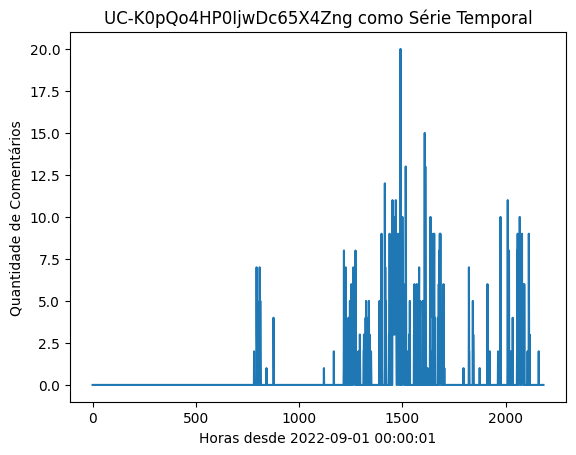

In [76]:
#df.filter("authorChannelId == 'UCeClaz4pAxODLA9aF5aSQDA'").head(500)
import matplotlib.pyplot as plt
selected_data = df.filter("authorChannelId == 'UC-K0pQo4HP0IjwDc65X4Zng'").select("publishedAt").collect()
dates = [row.publishedAt for row in selected_data]
formatted_dates = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in dates]
print(sorted(formatted_dates))

data = timestamp_frequency(formatted_dates, granularity='hours')
print(len(data))
#non_zero_indices = [i for i, val in enumerate(data) if val != 0]
#non_zero_values = [val for val in data if val != 0]
# Scatter plot of non-zero values
#plt.scatter(non_zero_indices, non_zero_values, color='r', label="Non-zero values")

# Optionally, you can also plot the entire data as a line plot for context
plt.plot(data)

plt.title("UC-K0pQo4HP0IjwDc65X4Zng como Série Temporal")
plt.ylabel("Quantidade de Comentários")
plt.xlabel("Horas desde 2022-09-01 00:00:01")
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

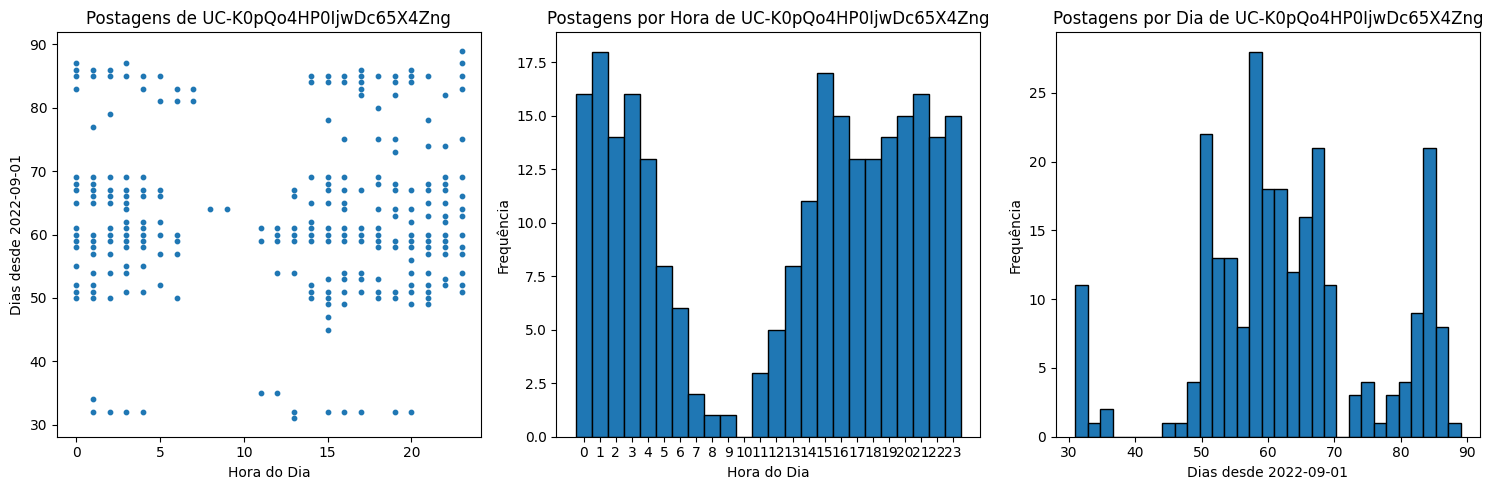

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Definindo a variável USUARIO no início
USUARIO = "UC-K0pQo4HP0IjwDc65X4Zng"  # Substitua "NOME_DO_USUÁRIO" pelo nome de usuário desejado

# Dados de amostra
# Nota: Estou assumindo que você já possui as funções e dados necessários.
unit = 'hours'
mat = create_sparse_matrix('2022-09-01 00:00:01', '2022-11-30 23:59:59', unit)
for d in formatted_dates:
    dia = (datetime.strptime(d, '%Y-%m-%d %H:%M:%S') - datetime.strptime('2022-09-01 00:00:01', '%Y-%m-%d %H:%M:%S')).days
    datetime_d = datetime.strptime(d, '%Y-%m-%d %H:%M:%S')
    if unit == 'seconds':
        index = datetime_d.hour * 3600 + datetime_d.minute * 60 + datetime_d.second
    elif unit == 'minutes':
        index = datetime_d.hour * 60 + datetime_d.minute
    elif unit == 'hours':
        index = datetime_d.hour
    mat[dia-1, index-1] += 1

matrix = mat.toarray()
dias, horas = matrix.shape

# Obtenha as coordenadas e tamanhos para o gráfico de dispersão
y, x = np.where(matrix > 0)

# Plotagem
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # layout de 1 linha, 3 colunas

# Gráfico de dispersão
axs[0].scatter(x, y, s=10)
axs[0].set_title(f'Postagens de {USUARIO}')
axs[0].set_xlabel('Hora do Dia')
axs[0].set_ylabel('Dias desde 2022-09-01')
#axs[0].invert_yaxis()  # Coloca o primeiro dia no topo

# Histograma para dados x (Horas)
axs[1].hist(x, bins=np.arange(-0.5, 24.5, 1), edgecolor='k', align='mid')
axs[1].set_title(f'Postagens por Hora de {USUARIO}')
axs[1].set_xlabel('Hora do Dia')
axs[1].set_ylabel('Frequência')
axs[1].set_xticks(np.arange(0, 24))

# Histograma para dados y (Dias)
axs[2].hist(y, bins=31, edgecolor='k', align='mid', orientation='vertical')
axs[2].set_title(f'Postagens por Dia de {USUARIO}')
axs[2].set_xlabel('Dias desde 2022-09-01')
axs[2].set_ylabel('Frequência')

plt.tight_layout()
plt.show()


In [80]:
df = df.dropDuplicates()
df = df.filter("publishedAt <= '2022-11-30 23:59:59'")
# Group by authorChannelId and count occurrences
author_counts = df.groupBy("authorChannelId").agg(count("*").alias("count"))

# Filter for authorChannelId with counts >= 500
valid_authors = author_counts.filter(author_counts["count"] >= 500)

# Join with the original dataframe to filter the rows
df = df.join(valid_authors, on="authorChannelId", how="inner").drop("count")
df = df.withColumn("publishedAt", from_utc_timestamp(unix_timestamp("publishedAt", "yyyy-MM-dd'T'HH:mm:ss'Z'").cast("timestamp"), "UTC"))

In [81]:

# Group by authorChannelId and videoId to count comments per video
comments_per_video = df.groupBy("authorChannelId", "videoId").agg(count("id").alias("num_comments_per_video"))

# Group by authorChannelId to count unique videoIds they've commented on
author_comments_count = comments_per_video.groupBy("authorChannelId").agg(
    count("videoId").alias("num_unique_videos_commented_on"),
    sum("num_comments_per_video").alias("total_comments")
).orderBy(desc("num_unique_videos_commented_on"), desc("total_comments"))

# Show the results
author_comments_count.toPandas().to_csv('/content/drive/My Drive/TCC/simple_metrics/author_comments_count.csv')
#author_comments_count.show()

In [82]:
#Busca por usuários que realizaram exatamente o mesmo comentário em vídeos diferentes:
duplicate_comments = df.groupBy("authorChannelId", "textOriginal") \
    .agg(collect_set("videoId").alias("videos")) \
    .withColumn("num_videos", size("videos")) \
    .filter(size("videos") > 1)

duplicate_comments.toPandas().to_csv('/content/drive/My Drive/TCC/simple_metrics/duplicate_comments.csv')
#duplicate_comments.show()

In [83]:
#Busca por usuários com comentários enviados ao mesmo tempo em diferentes vídeos ou em um curto espaço de tempo (segundos):
df_with_lag = df.withColumn("next_publishedAt", lead("publishedAt").over(Window.partitionBy("authorChannelId").orderBy("publishedAt")))
time_difference = (unix_timestamp("next_publishedAt") - unix_timestamp("publishedAt"))
same_time_comments = df_with_lag.filter((time_difference <= 10) & (time_difference >= 0))

same_time_comments.toPandas().to_csv('/content/drive/My Drive/TCC/simple_metrics/same_time_comments.csv')
#same_time_comments.show()

In [84]:
#Busca por grupos de usuários que realizam comentários em diferentes vídeos exatamente nos mesmos horários:
users_same_time = df.groupBy("publishedAt").agg(collect_set("authorChannelId").alias("users")).filter(size("users") > 1)

users_same_time.toPandas().to_csv('/content/drive/My Drive/TCC/simple_metrics/users_same_time.csv')
#users_same_time.show()

In [85]:
#Busca por grupos de usuários distintos que realizaram exatamente o mesmo comentário em um mesmo vídeo ou em um conjunto de vídeos:
users_same_comment = df.groupBy("textOriginal").agg(collect_set("authorChannelId").alias("users")).filter(size("users") > 1)

users_same_comment.toPandas().to_csv('/content/drive/My Drive/TCC/simple_metrics/users_same_comment.csv')
#users_same_comment.show()

In [86]:
#Busca por grupos de usuários distintos que comentam em conjunto em diferentes vídeos:
video_comments = df.groupBy("videoId").agg(collect_set("authorChannelId").alias("users")).filter(size("users") > 1)
#combined_comments = video_comments.alias("a").join(video_comments.alias("b"), size(array_intersect("a.users", "b.users")) > 1).filter("a.videoId != b.videoId")

video_comments.toPandas().to_csv('/content/drive/My Drive/TCC/simple_metrics/combined_comments.csv')
#combined_comments.show()

In [87]:
#Busca por usuários que realizam comentários em longos períodos de tempo (por exemplo, 1 comentário por hora durante 24 horas):
df_with_time_difference = df.withColumn("next_publishedAt", lead("publishedAt").over(Window.partitionBy("authorChannelId").orderBy("publishedAt")))
long_time_commenters = df_with_time_difference.filter((unix_timestamp("next_publishedAt") - unix_timestamp("publishedAt")) >= 3600).groupBy("authorChannelId").agg(count("id").alias("num_comments")).filter("num_comments >= 24")

long_time_commenters.toPandas().to_csv('/content/drive/My Drive/TCC/simple_metrics/long_time_commenters.csv')

#long_time_commenters.show()